Comment prédire le podium d'une course de Formule Un ? 

Librairies : 

In [ ]:
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt


Chargement des données : 

In [ ]:
drivers = pd.read_csv(os.path.join("donnees_formule_un", "drivers.csv")\
    , on_bad_lines='skip')
drivers.columns = drivers.columns.str.strip()
drivers["forename"] = drivers["forename"].str.replace('"', '').str.strip()
drivers["surname"] = drivers["surname"].str.replace('"', '').str.strip()
drivers["nom_complet"] = drivers["forename"] + " " + drivers["surname"]

constructors = pd.read_csv(os.path.join("donnees_formule_un", "constructors.csv"))
constructors.columns = constructors.columns.str.strip()

results = pd.read_csv(os.path.join("donnees_formule_un", "results.csv"))
results.columns = results.columns.str.strip()

races = pd.read_csv(os.path.join("donnees_formule_un", "races.csv"))
races.columns = races.columns.str.strip()

"""qualifying = pd.read_csv(os.path.join("donnees_formule_un", "qualifying.csv"))
qualifying.columns = qualifying.columns.str.strip()"""

print("drivers")
print(drivers.columns)
print("construtors")
print(constructors.columns)
print("races")
print(races.columns)
print("results")
print(results.columns)
"""print("qualifying")
print(qualifying.columns)"""

drivers
Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url', 'nom_complet'],
      dtype='object')
construtors
Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
races
Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')
results
Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')


Table énorme 

In [17]:
table_1 = pd.merge(races, results, on= "raceId")
table_2 = pd.merge(table_1, constructors, on = "constructorId")
table = pd.merge(table_2, drivers, on = "driverId")
print(table.columns)
#sélectionner les variables dans la table
table = table[['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder', 'grid']]

# table triée sur les années 2023 et 2024 :
df = table[(table['year'] == 2023) | (table['year'] == 2024)]
df = df.drop_duplicates(subset=['raceId', 'nom_complet']) # éviter les doublons
print(df.head())


Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time_y',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'constructorRef', 'name_y',
       'nationality_x', 'url_y', 'driverRef', 'number_y', 'code', 'forename',
       'surname', 'dob', 'nationality_y', 'url', 'nom_complet'],
      dtype='object')
       raceId  year                            name_x      nom_complet  \
25810    1098  2023   "Bahrain Grand Prix"              Max Verstappen   
25811    1098  2023   "Bahrain Grand Prix"                Sergio Pérez   
25812    1098  2023   "Bahrain Grand Prix"             Fernando Alonso   
25813    1098  2023   "Bahrain Gra

Info :
name_x = nom du circuit 
name_y = nom de constructeur 

Variables utilisées pour la régression logistique 

In [18]:

"""# Nombre de victoires par pilote
nb_victoire_2_ans = df[df["positionOrder"] == 1].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_victoire_2_ans.name = 'nb_victoire_2_ans'
# Fusionner avec le DataFrame df
if 'nb_victoire_2_ans' in df.columns:
    df = df.drop(columns=['nb_victoire_2_ans'])

df = df.merge(nb_victoire_2_ans, on = "nom_complet", how = "left")
df["nb_victoire_2_ans"] = df["nb_victoire_2_ans"].fillna(0)"""

# Nombre de podium par pilote
nb_podium_2_ans = df[(df["positionOrder"] == 1) | (df["positionOrder"] == 2)\
    | (df["positionOrder"] == 3)].groupby("nom_complet").size()
# Ajouter un nom à la Série pour pouvoir la fusionner
nb_podium_2_ans.name = 'nb_podium_2_ans'
if 'nb_podium_2_ans' in df.columns:
    df = df.drop(columns=['nb_podium_2_ans'])
# Fusionner avec le DataFrame df
df = df.merge(nb_podium_2_ans, on = "nom_complet", how = "left")
# Remplir les NaN avec 0
df["nb_podium_2_ans"] = df["nb_podium_2_ans"].fillna(0)


# Position au départ de la course
# correspond à la variable grid de df


# Ecurie actuelle du pilote
df['name_y'] = df['name_y'].str.strip('" ') #pour avoir un nom prore
# Supprimer les anciennes colonnes d'ecurie si elles existent déjà
df = df.loc[:, ~df.columns.str.startswith('ecurie_')]
# Ecurie actuelle du pilote
df['ecurie'] = df['name_y'].str.strip()    # très important de STRIP ici aussi !!
# One-Hot Encoding
ecuries_encoded = pd.get_dummies(df['ecurie'], prefix='ecurie')
# Ajouter les colonnes au DataFrame
df = pd.concat([df, ecuries_encoded], axis=1)


# Convertir tout booléen en int (True → 1, False → 0)
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# Position dans les championnats en 2023 et 2024
# correspond à  la variable position de la table driver standings

# Afficher les colonnes du DataFrame
df.columns = df.columns.str.strip()
print(df.columns)
print(df.head())


Index(['raceId', 'year', 'name_x', 'nom_complet', 'name_y', 'positionOrder',
       'grid', 'nb_podium_2_ans', 'ecurie', 'ecurie_Alfa Romeo',
       'ecurie_AlphaTauri', 'ecurie_Alpine F1 Team', 'ecurie_Aston Martin',
       'ecurie_Ferrari', 'ecurie_Haas F1 Team', 'ecurie_McLaren',
       'ecurie_Mercedes', 'ecurie_RB F1 Team', 'ecurie_Red Bull',
       'ecurie_Sauber', 'ecurie_Williams'],
      dtype='object')
   raceId  year                            name_x      nom_complet  \
0    1098  2023   "Bahrain Grand Prix"              Max Verstappen   
1    1098  2023   "Bahrain Grand Prix"                Sergio Pérez   
2    1098  2023   "Bahrain Grand Prix"             Fernando Alonso   
3    1098  2023   "Bahrain Grand Prix"                Carlos Sainz   
4    1098  2023   "Bahrain Grand Prix"              Lewis Hamilton   

         name_y  positionOrder  grid  nb_podium_2_ans        ecurie  \
0      Red Bull              1     1             30.0      Red Bull   
1      Red Bull      

Régression logistique 

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
X = df.drop(columns=colonnes_a_exclure)
y = df['sur_podium']
# traiter les valeurs manquantes
X = X.fillna(0)


# 4. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Prédictions
y_pred = model.predict(X_test)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")


Accuracy du modèle pour la prédiction du podium : 0.88


Une accuracy de 0.88 signifie que 88% des observations testées ont été bien classées. 

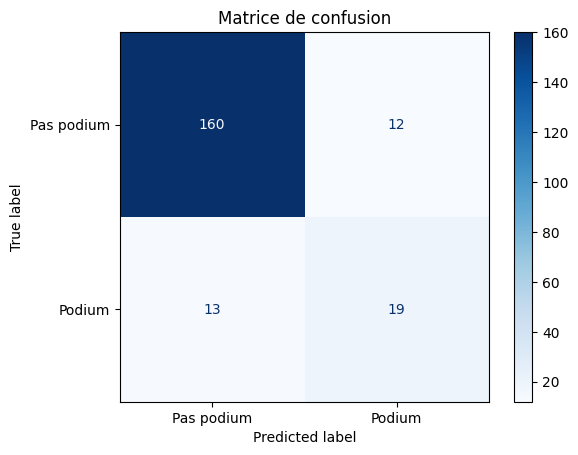

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.92      0.93      0.93       172
      Podium       0.61      0.59      0.60        32

    accuracy                           0.88       204
   macro avg       0.77      0.76      0.77       204
weighted avg       0.88      0.88      0.88       204



In [7]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))


Matrice de confusion : 160 vrais négatifs ; 19 vrais positifs ; 13 faux négatifs ; 12 faux positifs 

Rapport de classification : racall = taux de faux négatifs, le modèle rate des podium ou des non podium, plus il est faible plus le modèle rate ; precision = plus elle est faible plus le modèle prédit à tord ; F1 score = équilibre de ces deux aspects 

Conclusion : pour l'instant le modèle est déséquilibré, il est très bon pour prédire pas podium mais beaucoup moins pour prédire le podium. 



Pistes d'amélioration : tester la régression logistique avec class_weight="balanced", ce qui compense automatiquement le déséquilibre entre les classes.

Accuracy du modèle pour la prédiction du podium : 0.85


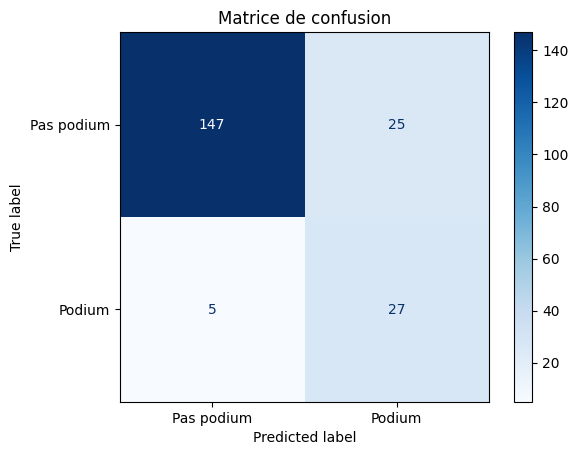

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.97      0.85      0.91       172
      Podium       0.52      0.84      0.64        32

    accuracy                           0.85       204
   macro avg       0.74      0.85      0.78       204
weighted avg       0.90      0.85      0.87       204

                  feature  coefficient
4   ecurie_Alpine F1 Team     1.053309
11        ecurie_Red Bull     0.728468
9         ecurie_Mercedes     0.452522
6          ecurie_Ferrari     0.256397
1         nb_podium_2_ans     0.229395
8          ecurie_McLaren     0.165333
5     ecurie_Aston Martin    -0.025360
10      ecurie_RB F1 Team    -0.227448
3       ecurie_AlphaTauri    -0.252556
0                    grid    -0.306331
12          ecurie_Sauber    -0.424999
2       ecurie_Alfa Romeo    -0.500568
13        ecurie_Williams    -0.537127
7     ecurie_Haas F1 Team    -0.749584


In [19]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
X = df.drop(columns=colonnes_a_exclure)
y = df['sur_podium']
# traiter les valeurs manquantes
X = X.fillna(0)


# 4. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

# 6. Prédictions
y_pred = model.predict(X_test)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# 2. Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))

# Connaître le poids de chaque variable

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)
print(coef_df)

problème : deux écuries changent de nom entre 2023 et 2024 : soit on les fusionne soit test que sur l'année 2024 et on tente de prédire la dernière course. 


 train = année 2023 ; test = année 2024

Accuracy du modèle pour la prédiction du podium : 0.82


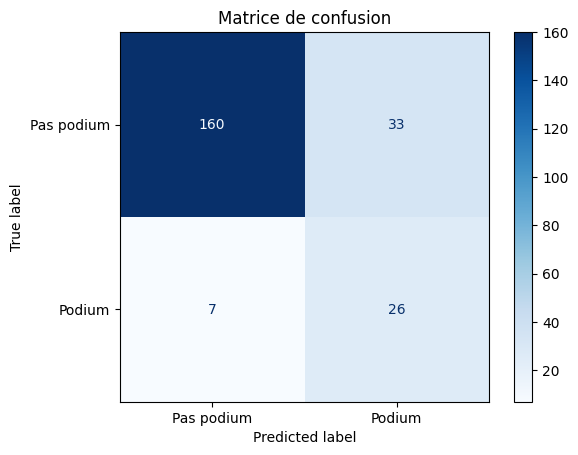

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.96      0.83      0.89       193
      Podium       0.44      0.79      0.57        33

    accuracy                           0.82       226
   macro avg       0.70      0.81      0.73       226
weighted avg       0.88      0.82      0.84       226

                  feature  coefficient
4   ecurie_Alpine F1 Team     0.915305
11        ecurie_Red Bull     0.880255
5     ecurie_Aston Martin     0.858696
9         ecurie_Mercedes     0.833408
1         nb_podium_2_ans     0.340982
10      ecurie_RB F1 Team     0.000000
12          ecurie_Sauber     0.000000
13        ecurie_Williams    -0.093927
3       ecurie_AlphaTauri    -0.189505
2       ecurie_Alfa Romeo    -0.225418
0                    grid    -0.288709
7     ecurie_Haas F1 Team    -0.363026
6          ecurie_Ferrari    -1.191146
8          ecurie_McLaren    -1.430276
Accuracy du modèle pour la prédiction du podium : 0.87


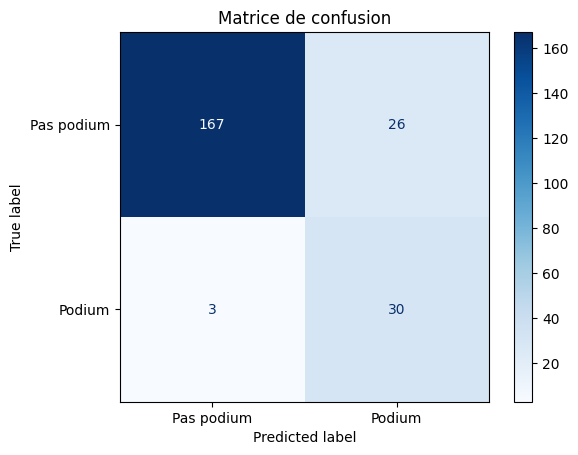

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.98      0.87      0.92       193
      Podium       0.54      0.91      0.67        33

    accuracy                           0.87       226
   macro avg       0.76      0.89      0.80       226
weighted avg       0.92      0.87      0.88       226

                  feature  coefficient
4   ecurie_Alpine F1 Team     1.036019
11        ecurie_Red Bull     0.659934
9         ecurie_Mercedes     0.590550
5     ecurie_Aston Martin     0.536443
1         nb_podium_2_ans     0.244014
8          ecurie_McLaren     0.099308
12          ecurie_Sauber    -0.003409
10      ecurie_RB F1 Team    -0.007554
0                    grid    -0.264987
6          ecurie_Ferrari    -0.405418
3       ecurie_AlphaTauri    -0.503128
13        ecurie_Williams    -0.550490
2       ecurie_Alfa Romeo    -0.586433
7     ecurie_Haas F1 Team    -0.970464


In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
X = df.drop(columns=colonnes_a_exclure)
y = df['sur_podium']
# traiter les valeurs manquantes
X = X.fillna(0)

# 4. Séparation train/test avec TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)  # Divisez les données en 2 ensembles temporels

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # 5. Entraîner le modèle
    model = LogisticRegression(max_iter=1000, class_weight="balanced")
    model.fit(X_train, y_train)

    # 6. Prédictions
    y_pred = model.predict(X_test)

    # 7. Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
    disp.plot(cmap="Blues")
    plt.title("Matrice de confusion")
    plt.show()

    # Rapport de classification
    print("Rapport de classification :")
    print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))

    # Poids des variables
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_[0]
    }).sort_values(by='coefficient', ascending=False)
    print(coef_df)



Accuracy du modèle pour la prédiction du podium : 0.85


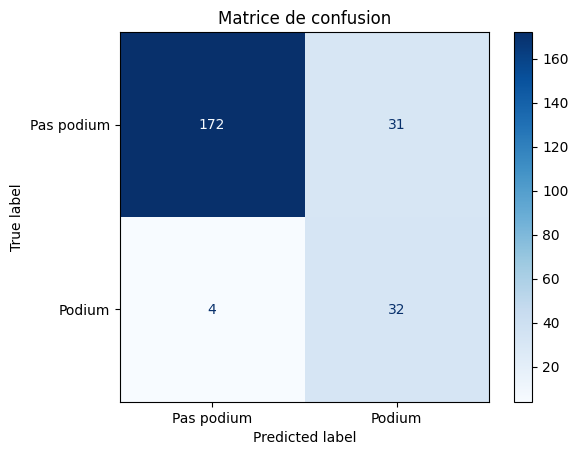

Rapport de classification :
              precision    recall  f1-score   support

  Pas podium       0.98      0.85      0.91       203
      Podium       0.51      0.89      0.65        36

    accuracy                           0.85       239
   macro avg       0.74      0.87      0.78       239
weighted avg       0.91      0.85      0.87       239

                  feature  coefficient
4   ecurie_Alpine F1 Team     1.078936
9         ecurie_Mercedes     0.648067
5     ecurie_Aston Martin     0.578564
11        ecurie_Red Bull     0.547967
1         nb_podium_2_ans     0.251785
8          ecurie_McLaren     0.143646
10      ecurie_RB F1 Team     0.000000
12          ecurie_Sauber     0.000000
0                    grid    -0.264078
3       ecurie_AlphaTauri    -0.493822
13        ecurie_Williams    -0.539853
6          ecurie_Ferrari    -0.541298
2       ecurie_Alfa Romeo    -0.575233
7     ecurie_Haas F1 Team    -0.948833


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Variable cible : sur le podium ou non
df["sur_podium"] = df["positionOrder"].isin([1, 2, 3]).astype(int)

# 2. Convertir les booléens en 0/1
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})

# 3. Définir les features (X) et la cible (y)
colonnes_a_exclure = ['raceId', 'year', 'name_x', 'name_y', 'nom_complet', 'ecurie', 'sur_podium', 'positionOrder']
X = df.drop(columns=colonnes_a_exclure)
y = df['sur_podium']

# Traiter les valeurs manquantes
X = X.fillna(0)

# 4. Séparation train/test sur base de l'année
df_2023 = df[df['year'] == 2023]
df_2024 = df[df['year'] == 2024]

X_train = df_2023.drop(columns=colonnes_a_exclure)
y_train = df_2023['sur_podium']
X_test = df_2024.drop(columns=colonnes_a_exclure)
y_test = df_2024['sur_podium']

# 5. Entraîner le modèle
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

# 6. Prédictions
y_pred = model.predict(X_test)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle pour la prédiction du podium : {accuracy:.2f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Pas podium", "Podium"]))

# Connaître le poids de chaque variable
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)
print(coef_df)
